# XGBoost for Classification Problem
Dataset: `Case_Data.csv`

In [21]:
# Imports
import os
import numpy as np
import pandas as pd

# Modeling
# train_test_split:   splits data into training and testing subsets
# KFold:              defines cross-validation folds (e.g., 5-fold CV)
from sklearn.model_selection import train_test_split, StratifiedKFold

# Pipeline:           chains preprocessing steps (scaling, encoding, model) into one object
#                     ensures consistent transformations during training and prediction
from sklearn.pipeline import Pipeline

#GridSearchCV:     provides the cv engine for trees which do not have one built in
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

# Metrics:               roc_auc_score gives a single number (AUC) to summarize model performance
#                        roc_curve gives the points to plot the ROC curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt  

#!pip install xgboost if not installed
from xgboost import XGBClassifier
# Reproducibility seeds
np.random.seed(87)  # used for train/test split

In [22]:
# Expect the file to be in the same folder as this notebook
df = pd.read_csv('Case_Data.csv' )
print(df.shape)
print(df.describe(include='all'))
print(df['TARGET'].value_counts())# summary stats

(20000, 68)
              TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
count   20000.000000              20000       20000        20000   
unique           NaN                  2           2            2   
top              NaN         Cash loans           F            N   
freq             NaN              18089       13189        13213   
mean        0.077450                NaN         NaN          NaN   
std         0.267311                NaN         NaN          NaN   
min         0.000000                NaN         NaN          NaN   
25%         0.000000                NaN         NaN          NaN   
50%         0.000000                NaN         NaN          NaN   
75%         0.000000                NaN         NaN          NaN   
max         1.000000                NaN         NaN          NaN   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count            20000  20000.000000      2.000000e+04  2.000000e+04   
unique               2     

## Step 1: Partition our Data and Pre-processing

In [23]:
# Turn categorical variables into dummy (0/1) columns
X = pd.get_dummies(df.drop(columns=["TARGET"]), drop_first=True)  

# Target variable
Y = df["TARGET"]

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((14000, 165), (6000, 165))

## Step 2 — Train/ Fit Model


In [24]:
# Determine classes and ordering
classes = pd.unique(pd.Series(Y_train).dropna())
classes

array([0, 1])

In [25]:
# Convert to 0,1 for XGBoost 
mapping = {c: int(c == 1) for c in classes}

Y_train = pd.Series(Y_train).map(mapping).to_numpy()
Y_test = pd.Series(Y_test).map(mapping).to_numpy()

In [26]:

# 1) CV split (same as before)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)


# 3) Pipeline with XGBoost model
xgb_pipe = Pipeline([
    ("model", XGBClassifier(
        objective="binary:logistic",
        n_jobs=-1,          # use all cores
        eval_metric="auc",  # pairs well with scoring="roc_auc"
        tree_method="hist", # fast CPU histogram algorithm (use "gpu_hist" if you have a GPU)
        random_state=99
    ))
])

# 4) Hyperparameter grid (reasonable, compact search)
param_grid = {
    "model__n_estimators": [400, 800],
    "model__max_depth":    [4, 6, 8],
    "model__learning_rate":[0.05, 0.1],
    "model__subsample":    [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__min_child_weight": [1, 3]
}

# 5) Cross-validated grid search (same scoring)
xgb_cv = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True
)

# 6) Fit with per-sample weights
xgb_cv.fit(X_train, Y_train)

print("Positive class used by AUC:", xgb_cv.best_estimator_.named_steps["model"].classes_[1])
print("Best params selected by CV:", xgb_cv.best_params_)
print("Best CV ROC-AUC:", round(xgb_cv.best_score_, 3))

Positive class used by AUC: 1
Best params selected by CV: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__subsample': 0.8}
Best CV ROC-AUC: 0.719


### Now determine feature importance

                                              feature  importance
26                                       EXT_SOURCE_3    0.020320
25                                       EXT_SOURCE_2    0.020151
56                                      CODE_GENDER_M    0.018047
75  NAME_EDUCATION_TYPE_Secondary / secondary special    0.016185
72               NAME_EDUCATION_TYPE_Higher education    0.014132
71                           NAME_INCOME_TYPE_Working    0.014018
33                                    FLAG_DOCUMENT_3    0.013861
28                           DEF_30_CNT_SOCIAL_CIRCLE    0.013235
84                     NAME_HOUSING_TYPE_With parents    0.011559
4                                     AMT_GOODS_PRICE    0.011145
55                 NAME_CONTRACT_TYPE_Revolving loans    0.011059
22                             REG_CITY_NOT_LIVE_CITY    0.011016
76                         NAME_FAMILY_STATUS_Married    0.010787
6                                          DAYS_BIRTH    0.010775
80        

<Figure size 800x600 with 0 Axes>

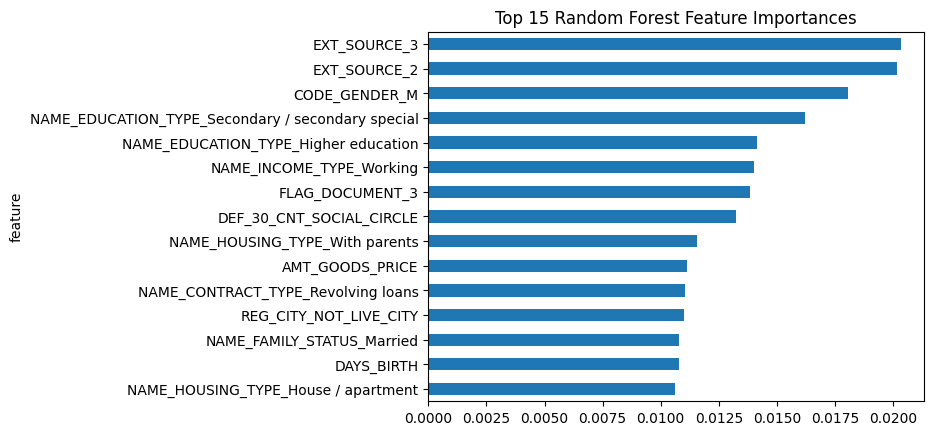

In [27]:
# Get best fitted model from GridSearchCV
best_xgb = xgb_cv.best_estimator_.named_steps["model"]

# Get feature importances (aligned with columns of X_train)
importances = best_xgb.feature_importances_
features = X_train.columns

# Put in DataFrame for clarity
feat_imp = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp.head(15))  # top 15 features

# Optional: plot top features
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()



## Step 3: Predictions for Test Set

In [28]:
#determine class order of your response variable
classes = xgb_cv.best_estimator_.named_steps["model"].classes_
print("Class order:", classes)

Class order: [0 1]


In [29]:

pos_idx = list(classes).index(1)   #Put in the class you are trying to predict
proba = xgb_cv.predict_proba(X_test)[:, pos_idx]


## Step 4: Calculate test set ROC/AUC using predicted probabilities from test set

ROC AUC (test): 0.730


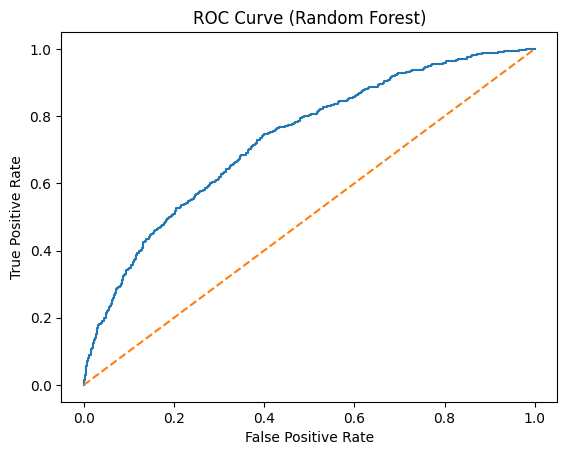

In [30]:
# ROC curve + AUC (tell roc_curve which label is positive)
pos_label=1 
fpr, tpr, _ = roc_curve(Y_test, proba, pos_label=pos_label)
roc_auc = roc_auc_score((Y_test == pos_label).astype(int), proba)
print(f"ROC AUC (test): {roc_auc:.3f}")
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.show()